In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import re
import warnings
warnings.filterwarnings('ignore')

In [4]:
from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.family'] =  "sans-serif" 
rcParams['font.sans-serif'] = "Liberation Sans"  # font Arial
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [5]:
Datadir="/data2/linzhuobin/Hap3D_Figures/figure_processing_data"
fhap_list=f'{Datadir}/Fig3/frag-hap.list' ## dip3d filter
hic_list=f'{Datadir}/Fig3/hic-hap.list'
hic_pair=f'{Datadir}/Fig3/hic-hap.pair'
out_dir='/data2/linzhuobin/Hap3D_Figures/pdf'

In [6]:
import os
if os.path.isfile(hic_pair):
    print("Hic pair-wise contact file exists")
    hic=pd.read_csv(hic_pair,header=None,sep='\t',names=['read_name','chrom1','pos1','hp1','chrom2','pos2','hp2'])
else:
    print("Hic pair-wise contact file does not exist")
    hicraw=pd.read_csv(hic_list,header=None,sep='\t',names=['read_name','chrom','pos','hp'])
    hicraw=hicraw.astype(str)
    hicraw = hicraw.sort_values(by=["read_name", "chrom", "pos"])

    # generate hic contact matrix 
    l_df = hicraw.drop_duplicates(subset='read_name', keep='first') # 
    r_df = hicraw.drop_duplicates(subset='read_name', keep='last') #
    hic = pd.merge(l_df, r_df, on='read_name', suffixes=('1', '2'))
    hic.to_csv(hic_pair, header=False, index=False, sep="\t") # Export to file
    
hic.head()

Hic pair-wise contact file exists


,read_name,chrom1,pos1,hp1,chrom2,pos2,hp2
0,SRR5122741.1000,7,56869833,G1,7,56893276,UA
1,SRR5122741.1000000,3,110839538,UA,3,123790652,G2
2,SRR5122741.10000000,4,121573519,UA,4,27554451,UA
3,SRR5122741.10000003,X,159654814,UA,X,97735573,G1
4,SRR5122741.10000004,5,50751463,UA,5,70088050,G1


In [7]:
#chrom_type
hic["chrom_type"] = "inter"
P = hic.chrom1 == hic.chrom2
hic.loc[P, "chrom_type"] = "intra"

# phase_type
hic["phase_type"] = "one"
P1 = (hic.hp1=="UA") & (hic.hp2=="UA")
hic.loc[P1, "phase_type"] = "none"
P2 = (hic.hp1!="UA") & (hic.hp2!="UA")
hic.loc[P2, "phase_type"] = "two"

# contact_type
hic["contact_type"] = "unknown"
P = hic.phase_type == "two"
P1 = hic.chrom_type == "inter"
hic.loc[P&P1, "contact_type"] = "trans"
P2 = hic.hp1 == hic.hp2
hic.loc[P&P2&(~P1), "contact_type"] = "cis"
P3 = hic.hp1 != hic.hp2
hic.loc[P&P3&(~P1), "contact_type"] = "htrans"

# distance
hic["distance"] = -1
P = (hic.contact_type=="htrans") | ( hic.contact_type == "cis")
hic.loc[P, "distance"] = ( hic.loc[P, "pos1"].astype(int) - hic.loc[P, "pos2"].astype(int) ).abs()
hic

,read_name,chrom1,pos1,hp1,chrom2,pos2,hp2,chrom_type,phase_type,contact_type,distance
0,SRR5122741.1000,7,56869833,G1,7,56893276,UA,intra,one,unknown,-1
1,SRR5122741.1000000,3,110839538,UA,3,123790652,G2,intra,one,unknown,-1
2,SRR5122741.10000000,4,121573519,UA,4,27554451,UA,intra,none,unknown,-1
3,SRR5122741.10000003,X,159654814,UA,X,97735573,G1,intra,one,unknown,-1
4,SRR5122741.10000004,5,50751463,UA,5,70088050,G1,intra,one,unknown,-1
...,...,...,...,...,...,...,...,...,...,...,...
50426084,SRR5122742.9999994,9,117382808,G1,9,118101933,G1,intra,two,cis,719125
50426085,SRR5122742.9999995,6,100562309,UA,6,100656277,UA,intra,none,unknown,-1
50426086,SRR5122742.9999996,13,54555593,G1,13,54571458,UA,intra,one,unknown,-1
50426087,SRR5122742.9999997,13,75835309,UA,13,76248714,UA,intra,none,unknown,-1


In [11]:
# ## Fig. xx: hybrid mouse Hi-C characteristic
### chrom_type
intra=hic.chrom_type.value_counts()['intra']/len(hic)*100
inter=hic.chrom_type.value_counts()['inter']/len(hic)*100

# sizes=[intra,inter]
# labels=['Intra-chromosome','Inter-chromosome']
# colors=['#8ECFC9','#ff8884']
# explode = (0.05, 0)
# fig, ax = plt.subplots(figsize=(4,4))
# ax.pie(sizes, labels=labels, autopct='%1.2f%%',startangle=125,colors=colors,explode=explode)

# fign=out_dir+'/Hi-C.chrom_type.pdf'
# fig.savefig(fign,dpi=300,bbox_inches = 'tight')

### phase_type
intra_hic=hic.loc[hic.chrom_type=='intra']
# one=intra_hic.phase_type.value_counts()['one']/len(intra_hic)*100
# two=intra_hic.phase_type.value_counts()['two']/len(intra_hic)*100
# none=intra_hic.phase_type.value_counts()['none']/len(intra_hic)*100

# sizes=[none,one,two]
# labels=['Unphased','One-end','Two-end']
# colors=sns.color_palette('Blues', 3)
# explode = (0, 0, 0.05)
# fig, ax = plt.subplots(figsize=(4,4))
# ax.pie(sizes, labels=labels, autopct='%1.2f%%',startangle=45,colors=colors,explode=explode)

# fign=out_dir+'/Hi-C.intra_phase_type.pdf'
# fig.savefig(fign,dpi=300,bbox_inches = 'tight')

### contact_type
phase_hic=intra_hic.loc[intra_hic.contact_type!='unknown']
cis=phase_hic.contact_type.value_counts()['cis']/len(phase_hic)*100
htrans=phase_hic.contact_type.value_counts()['htrans']/len(phase_hic)*100

# sizes=[cis,htrans]
# labels=['Cis','H-trans']
# colors=['#FFBE7A','#9E9E9E']
# explode = (0.05, 0)
# fig, ax = plt.subplots(figsize=(4,4))
# ax.pie(sizes, labels=labels, autopct='%1.2f%%',startangle=93,colors=colors,explode=explode)

# fign=out_dir+'/Hi-C.intra_phase_contact_type.pdf'
# fig.savefig(fign,dpi=300,bbox_inches = 'tight')

In [9]:
def add_flatten_lists(the_lists):
    result = []
    for _list in the_lists:
        result += _list
    return result

def stats_Hap(df):
    df=df.loc[df.hp!=0,]
    df=df.sort_values(['rid','pos']).reset_index(drop=True)
    statsdf=df.groupby('rid')['pos'].apply(list).reset_index()
    statsdf['hp']=df.groupby('rid')['hp'].apply(list).reset_index()['hp']
    statsdf['fnum']=statsdf['pos'].apply(lambda x: len(x))
    statsdf=statsdf.loc[statsdf.fnum>1,]

    statsdf['isize']=statsdf.pos.apply(lambda x: [abs(i[0]-i[1]) for i in list(combinations(x,2))])
    statsdf['ihp']=statsdf.hp.apply(lambda x: [i[0]+i[1] for i in list(combinations(x,2))])
    statsdf['ihp']=statsdf.ihp.apply(lambda x: ['h' if i==3 else 'c' for i in x])

    statsdf['fid']=df.groupby('rid')['fid'].apply(list).reset_index()['fid']
    statsdf['adj']=statsdf.fid.apply(lambda x: ['a' if abs(i[0]-i[1])==1 else 'u' for i in list(combinations(x,2)) ])
    
    isize=add_flatten_lists(statsdf.isize)
    ihp=add_flatten_lists(statsdf.ihp)
    adj=add_flatten_lists(statsdf.adj)

    sdf=pd.DataFrame({'isize':isize,'ihp':ihp,'adj':adj})
    return sdf

def cal_htrans(sdf,min_freq=10,binsize=10**5,plotx=10**6,lowess_frac=0.05):
    sdf['bin_isize']=sdf.isize.apply(lambda x: round(x/binsize)*binsize)
    sdf=sdf.groupby(['bin_isize','ihp'])['isize'].count().reset_index()
    sdf.columns=['bin_isize','interaction','freq']
    sdf=sdf.sort_values(['bin_isize','interaction']).reset_index(drop=True)

    hdf=sdf.groupby('bin_isize')['interaction'].apply(list).reset_index()
    hdf['freq']=sdf.groupby('bin_isize')['freq'].apply(list).reset_index()['freq']
    hdf['total_freq']=hdf.freq.apply(lambda x: sum(x))
    hdf=hdf.loc[hdf.total_freq>=min_freq,]
    hdf['itype']=hdf.interaction.apply(lambda x: 'b' if len(x)==2 else x[0])
    hdf['hratio']=hdf.apply(lambda x: x.freq[1]/(x.total_freq)*100 if x.itype=='b' else 0 if x.itype=='c' else 100,axis=1)
    hdf['bin_isize']=hdf.bin_isize/plotx
    
    hdf['lowess_hratio'] = lowess(hdf['hratio'],hdf['bin_isize'],frac=lowess_frac)[:,1]
    return hdf

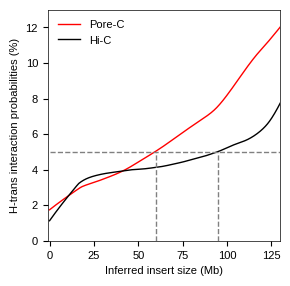

In [12]:
## Fig. 3B: H-trans varies with pairwise distance
### Pore-C Total
fhap=pd.read_csv(fhap_list,header=None,sep='\t',names=['rid','fid','cid','pos','hp'])
sdf=stats_Hap(fhap)
hdf=cal_htrans(sdf,lowess_frac=0.2)
total_hdf=hdf.copy()

### Pore-C Adjacent
#hdf=cal_htrans(sdf.loc[sdf.adj=='a'],lowess_frac=0.2)
#adj_hdf=hdf.copy()

### Hi-C
sdf=phase_hic[['distance','contact_type']]
sdf.columns=['isize','ihp']
hdf=cal_htrans(sdf,lowess_frac=0.2)
hic_hdf=hdf.copy()

disthred = 130
total_hdf = total_hdf.loc[total_hdf.bin_isize<=disthred, :]
hic_hdf = hic_hdf.loc[hic_hdf.bin_isize<=disthred, :]


plt.figure(figsize = (3,3)) 
plt.plot(total_hdf['bin_isize'],total_hdf['lowess_hratio'],color='r')
#plt.plot(adj_hdf['bin_isize'],adj_hdf['lowess_hratio'],color='g')
plt.plot(hic_hdf['bin_isize'],hic_hdf['lowess_hratio'],color='k')
#plt.legend(['Total','Adjacent','Hi-C'],frameon=False)
plt.legend(['Pore-C','Hi-C'],frameon=False)

plt.plot([0,130],[5,5],color='grey',linestyle='--',linewidth=1)
plt.plot([60,60],[0,5],color='grey',linestyle='--',linewidth=1)
#plt.plot([70,70],[0,5],color='grey',linestyle='--',linewidth=1)
plt.plot([95,95],[0,5],color='grey',linestyle='--',linewidth=1)

plt.xlim(-1,130)
plt.ylim(0,13)
plt.xlabel('Inferred insert size (Mb)')
plt.ylabel('H-trans interaction probabilities (%)')

fign=out_dir+'/mouse_H-trans_threshold.pdf'
plt.savefig(fign,dpi=300,bbox_inches = 'tight')

In [13]:
P = fhap.hp != 0
sum(P) / len(fhap)

0.6235671293227067

In [18]:
## Description of multi-way reads
### read-level phasing stats
df=fhap.groupby('rid')['hp'].apply(list).reset_index()
df['h1']=df.hp.apply(lambda x: x.count(1) if 1 in x else 0)
df['h2']=df.hp.apply(lambda x: x.count(2) if 2 in x else 0)
df['un']=df.hp.apply(lambda x: x.count(0) if 0 in x else 0)
df['hp']=df['h1']+df['h2']
df['fc']=df['hp']+df['un']
df['mod_fc']=df.fc.apply(lambda x: x if x<=10 else 10)
df['ratio']=df.apply(lambda x: round(x.hp/x.fc*100,2),axis=1)
### multi-way reads with multiple phased fragments
multi_phase_df=df.loc[df.hp>=3]
multi_phase_all=len(multi_phase_df)/len(df)*100
multi_phase_multi=len(multi_phase_df)/sum(df.fc>=3)*100
print(multi_phase_all,multi_phase_multi)

multi_phase_df['phase_type']=multi_phase_df.apply(lambda x: 'hetero' if x.h1>0 and x.h2>0 else 'homo',axis=1)
multi_phase_homo=multi_phase_df.phase_type.value_counts()['homo']/len(multi_phase_df)*100
print(multi_phase_homo)

multi_phase_df['hp_fold']=multi_phase_df.apply(lambda x: 0 if x.phase_type=='homo' else max(x.h1,x.h2)/min(x.h1,x.h2),axis=1)

## multi-way reads with multiple phased fragments, complete phased reads only
com_multi_phase_df=multi_phase_df.loc[multi_phase_df.ratio==100]
com_multi_phase_all=len(com_multi_phase_df)/len(df)*100
com_multi_phase_multi=len(com_multi_phase_df)/sum(df.fc>=3)*100
print(com_multi_phase_all,com_multi_phase_multi)

com_multi_phase_homo=com_multi_phase_df.phase_type.value_counts()['homo']/len(com_multi_phase_df)*100
print(com_multi_phase_homo)

25.651714809116015 60.857735979618155
95.23462071083182
8.003612340917014 18.988271558112128
95.4632264099466


Fragment_count
1     39.991234
2     17.858471
3     13.296487
4     10.038908
5      6.959449
6      4.553718
7      2.852517
8      1.767528
9      1.077892
10     1.603795
Name: Phased_Frag_propotion, dtype: float64


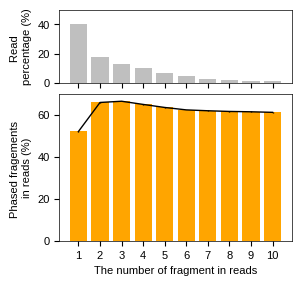

In [22]:
## Fig. 3C: Mouse Ratio of phased fragments
### read-level phasing stats
from scipy import stats
plotdf =  pd.DataFrame({
    'Fragment_count': df.mod_fc.values,
    'Phased_Frag_propotion': df.ratio.values})
#print(plotdf)
# Calculate means and standard deviations
grouped = plotdf.groupby('Fragment_count')['Phased_Frag_propotion']
means = grouped.mean()
stds = grouped.std()
sems = grouped.apply(stats.sem)
lower = grouped.apply(lambda x: stats.t.interval(0.95, len(x) -1, loc=np.mean(x), scale=stats.sem(x) )[0] )
CIs = means - lower
#print(sems, CIs)

# Calculate counts
counts = grouped.count() 
cPercent = 100*counts / len(plotdf)
print(cPercent)
# Create a new figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(3, 3), sharex=True, gridspec_kw={'height_ratios': [2, 4]})
fig.subplots_adjust(hspace=0.1)  # Reduce space between plots

# Plot counts as a bar plot on the top subplot
axs[0].bar(range(len(counts) ), cPercent, color='grey', alpha=0.5)
axs[0].set_ylabel('Read \npercentage (%)')
axs[0].set_ylim([0, 50])

# Plot means
axs[1].bar(range(len(means)), means.values, yerr=CIs, capsize=5, color='orange')
axs[1].plot(range(len(means)), means.values, "-",color='k')
# # Fill the area between mean + std and mean - std
# axs[1].fill_between(range(len(means)), means - stds, means + stds, color='blue', alpha=0.2)
#axs[1].set_ylim([0, 30])
axs[1].set_ylabel('Phased fragements \nin reads (%)')


plt.xticks(range(0,10), means.index)  # Set x-ticks to be group names
#plt.title('Mean ± std value curve for each group with counts')
plt.xlabel("The number of fragment in reads")
#plt.show()
fig=out_dir+'/Mouse_Ratio_of_phased_fragments_0629.pdf'
plt.savefig(fig,dpi=300,bbox_inches = 'tight')

In [15]:
# ## Description of multi-way reads
# ### read-level phasing stats
# df=fhap.groupby('rid')['hp'].apply(list).reset_index()
# df['h1']=df.hp.apply(lambda x: x.count(1) if 1 in x else 0)
# df['h2']=df.hp.apply(lambda x: x.count(2) if 2 in x else 0)
# df['un']=df.hp.apply(lambda x: x.count(0) if 0 in x else 0)
# df['hp']=df['h1']+df['h2']
# df['fc']=df['hp']+df['un']
# df['mod_fc']=df.fc.apply(lambda x: x if x<=10 else 10)
# df['ratio']=df.apply(lambda x: round(x.hp/x.fc*100,2),axis=1)
# ### multi-way reads with multiple phased fragments
# multi_phase_df=df.loc[df.hp>=3]
# multi_phase_all=len(multi_phase_df)/len(df)*100
# multi_phase_multi=len(multi_phase_df)/sum(df.fc>=3)*100
# print(multi_phase_all,multi_phase_multi)

# multi_phase_df['phase_type']=multi_phase_df.apply(lambda x: 'hetero' if x.h1>0 and x.h2>0 else 'homo',axis=1)
# multi_phase_homo=multi_phase_df.phase_type.value_counts()['homo']/len(multi_phase_df)*100
# print(multi_phase_homo)

# multi_phase_df['hp_fold']=multi_phase_df.apply(lambda x: 0 if x.phase_type=='homo' else max(x.h1,x.h2)/min(x.h1,x.h2),axis=1)

# ### multi-way reads with multiple phased fragments, complete phased reads only
# com_multi_phase_df=multi_phase_df.loc[multi_phase_df.ratio==100]
# com_multi_phase_all=len(com_multi_phase_df)/len(df)*100
# com_multi_phase_multi=len(com_multi_phase_df)/sum(df.fc>=3)*100
# print(com_multi_phase_all,com_multi_phase_multi)

# com_multi_phase_homo=com_multi_phase_df.phase_type.value_counts()['homo']/len(com_multi_phase_df)*100
# print(com_multi_phase_homo)

In [16]:
df

,rid,hp,h1,h2,un,fc,mod_fc,ratio
0,8,2,2,0,1,3,3,66.67
1,25,2,2,0,1,3,3,66.67
2,27,1,0,1,4,5,5,20.00
3,31,0,0,0,1,1,1,0.00
4,45,1,0,1,0,1,1,100.00
...,...,...,...,...,...,...,...,...
2564537,19180091,5,0,5,2,7,7,71.43
2564538,19180098,2,2,0,1,3,3,66.67
2564539,19180104,0,0,0,1,1,1,0.00
2564540,19180110,1,1,0,0,1,1,100.00


In [19]:
## Description of h-trans bridge
### h-trans bridge: 1..2..1 or 2..1..2
hetero_rid=multi_phase_df.loc[multi_phase_df.phase_type=='hetero'][['rid']]
hetero_fhap=pd.merge(fhap,hetero_rid)
hetero_fhap['hp']=hetero_fhap.hp.astype(str)
hetero_rhap=hetero_fhap.loc[hetero_fhap.hp!='0'].sort_values(['rid','fid']).groupby('rid')['hp'].apply(list).reset_index()
hetero_rhap['hp']=hetero_rhap.hp.apply(lambda x: ''.join(x))
hetero_rhap['htrans_bridge']=hetero_rhap.hp.apply(lambda x: len(re.findall('12+?1',x))+len(re.findall('21+?2',x)))
### reads with h-trans bridge
htrans_bridge_rnum=len(hetero_rhap)-hetero_rhap.htrans_bridge.value_counts()[0]
htrans_bridge_all=htrans_bridge_rnum/len(df)*100
htrans_bridge_multi=htrans_bridge_rnum/sum(df.fc>=3)*100
htrans_bridge_hetero=htrans_bridge_rnum/len(hetero_rhap)*100
print(htrans_bridge_all,htrans_bridge_multi,htrans_bridge_hetero)

0.4768492775708099 1.1313071134785497 39.009218794857894


In [20]:
## Description of fragment with minor hp
### fragment with minor hp in complete phased multi-way reads
com_multi_phase_df['minor_hp']=com_multi_phase_df.apply(lambda x: min(x.h1,x.h2),axis=1)
com_multi_minor_fnum=com_multi_phase_df.minor_hp.sum()
com_multi_minor_com=com_multi_minor_fnum/com_multi_phase_df.fc.sum()*100
print(com_multi_minor_com)

### fragment with minor hp in complete phased reads
com_phase_df=df.loc[df.ratio==100]
com_phase_df['minor_hp']=com_phase_df.apply(lambda x: min(x.h1,x.h2),axis=1)
com_minor_fnum=com_phase_df.minor_hp.sum()
com_minor_com=com_minor_fnum/com_phase_df.fc.sum()*100
print(com_minor_com)

1.3404241407118413
1.19689665778437


In [21]:
## Description
### ratio of phased fragments
phase_fratio=df.hp.sum()/df.fc.sum()*100
print(phase_fratio)

62.356712932270675


In [22]:
## Fig3 Fragment percentage and h1, h2 percentage
df["Tag"] = "Mouse"
df["HType"] = "h-trans"
P1 = df.h1 == df.hp
P2 = df.h2 == df.hp
P3 = df.ratio == 0
df.loc[P1, "HType"] = "h1"
df.loc[P2, "HType"] = "h2"
df.loc[P3, "HType"] = "unknown"

## (h1/h2) h-trans ratio
df["HTR"] = 0

## filter frag>=3
df_frag3 = df.loc[df.fc>=3, :]
df_frag3

,rid,hp,h1,h2,un,fc,mod_fc,ratio,Tag,HType,HTR
0,8,2,2,0,1,3,3,66.67,Mouse,h1,0
1,25,2,2,0,1,3,3,66.67,Mouse,h1,0
2,27,1,0,1,4,5,5,20.00,Mouse,h2,0
6,56,0,0,0,3,3,3,0.00,Mouse,unknown,0
7,57,1,1,0,3,4,4,25.00,Mouse,h1,0
...,...,...,...,...,...,...,...,...,...,...,...
2564534,19180065,2,0,2,2,4,4,50.00,Mouse,h2,0
2564535,19180074,4,0,4,2,6,6,66.67,Mouse,h2,0
2564537,19180091,5,0,5,2,7,7,71.43,Mouse,h2,0
2564538,19180098,2,2,0,1,3,3,66.67,Mouse,h1,0


In [23]:
df["mod_hp"] = df["hp"].values
df.loc[df.hp>=3, "mod_hp"] = 3
print( "Fragment distribution", 100* df.groupby("mod_hp")["Tag"].count() / len(df)  )

Fragment distribution mod_hp
0    23.069694
1    32.650274
2    18.628316
3    25.651715
Name: Tag, dtype: float64


In [24]:
df_frag3.groupby("HType")["Tag"].count()/len(df_frag3)

HType
h-trans    0.037195
h1         0.457381
h2         0.473068
unknown    0.032355
Name: Tag, dtype: float64

HType percentage HType
h-trans     3.719465
h1         45.738148
h2         47.306843
unknown     3.235544
Name: Tag, dtype: float64


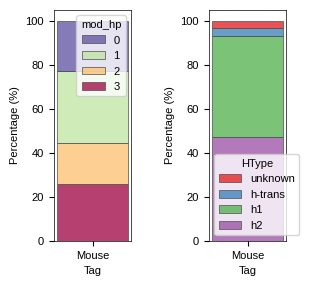

In [25]:
## Fig3 Fragment percentage and h1, h2 percentage
fig, axs = plt.subplots(1, 2, figsize=(3, 3), sharex=True)
fig.subplots_adjust(wspace=1)  # Reduce space between plots
## reads count percentage
sns.histplot(df, x="Tag", 
             hue="mod_hp", 
             hue_order = [0,1,2,3],
             multiple = "stack", 
             stat  = "percent",
             palette='Spectral_r',
            edgecolor=".3",
            linewidth=.5,
            binwidth=0.5,
            ax= axs[0])
#axs[0].set_xlabel("Mouse")
axs[0].set_ylabel("Percentage (%)")

## reads phased fragments hp1, hp2, h-trans
sns.histplot(df_frag3, x="Tag", 
             hue="HType", 
             hue_order = ["unknown","h-trans","h1","h2"],
             multiple = "stack", 
             stat  = "percent",
             palette='Set1',
            edgecolor=".3",
            linewidth=.5,
            binwidth=0.5,
            ax= axs[1])

#axs[1].set_xlabel("Mouse")
axs[1].set_ylabel("Percentage (%)")
#plt.show()
fig=out_dir+'/mouse_Fragment_phased_percentage.pdf'
plt.savefig(fig,dpi=300,bbox_inches = 'tight')

print( "HType percentage", 100* df_frag3.groupby("HType")["Tag"].count() / len(df_frag3)  )

In [32]:
# ## h-trans log2(h1/h2 ) ratio
# fig, axs = plt.subplots(9, 1, figsize=(3, 6), sharex=True)
# fig.subplots_adjust(hspace=0.05)  # Reduce space between plots

# sns.distplot( df_frag3.loc[df_frag3.HType=="h-trans", "HTR"], ax= axs[0] )
# axs[0].set_ylabel("All\nh-trans\nreads")
# axs[0].set_yticks([])
# for n in range(1, 9):
#     sns.distplot( df_frag3.loc[(df_frag3.HType=="h-trans")&(df_frag3.fc==n+2), "HTR"], ax= axs[n] )
#     axs[n].set_ylabel(f"{n+2}")
#     axs[n].set_yticks([])
# plt.xlabel("Log2(hp1/hp2)")
# #plt.show()
# fig=out_dir+'/Trans_reads_hp1_hp2_ratio.pdf'
# plt.savefig(fig,dpi=300,bbox_inches = 'tight')

In [26]:
df_frag3.HType.unique()

array(['h1', 'h2', 'unknown', 'h-trans'], dtype=object)

Reads distribution HType    mod_fc
h-trans  3         0.028435
         4         0.032251
         5         0.035775
         6         0.042275
         7         0.048842
         8         0.055549
         9         0.060413
         10        0.075954
h1       3         0.453424
         4         0.463341
         5         0.463559
         6         0.458187
         7         0.456134
         8         0.450705
         9         0.450892
         10        0.437734
h2       3         0.458166
         4         0.472041
         5         0.480625
         6         0.486025
         7         0.486740
         8         0.488429
         9         0.484716
         10        0.484391
unknown  3         0.059975
         4         0.032367
         5         0.020042
         6         0.013512
         7         0.008284
         8         0.005317
         9         0.003979
         10        0.001921
Name: Tag, dtype: float64


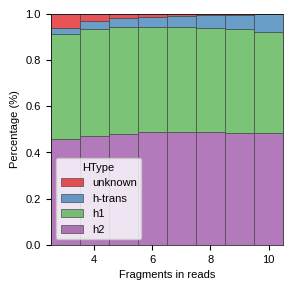

In [28]:
fig = plt.figure(figsize=(3,3))
## reads phased fragments hp1, hp2, h-trans
sns.histplot(df_frag3, x="mod_fc", 
             hue="HType", 
             hue_order = ['unknown',"h-trans","h1","h2"],
             multiple = "fill", 
             stat  = "percent",
             palette='Set1',
            edgecolor=".3",
            linewidth=.5,
            binwidth=0.5,
            discrete = True)
plt.xlabel("Fragments in reads")
plt.ylabel("Percentage (%)")
#plt.show()
fig=out_dir+'/mouse_H-trans_h1_h2_reads_ratio.pdf'
plt.savefig(fig,dpi=300,bbox_inches = 'tight')
print( "Reads distribution", df_frag3.groupby(["HType","mod_fc"])["Tag"].count() / df_frag3.groupby(["mod_fc"])["Tag"].count() )

All_phased_Reads ratio: 0.371
All_phased_Reads ratio (>3 fragment) : 0.190
All_phased_Reads ratio (>3 fragment) : 0.080
All_phased_Reads Haplotypes count: HType
h-trans    0.045368
h1         0.505018
h2         0.449614
Name: Tag, dtype: float64


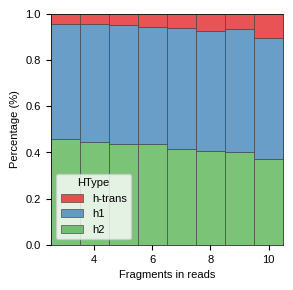

In [31]:
# Reads without unknown phased fragments
P = df.un == 0
print("All_phased_Reads ratio: %.3f"%(sum(P)/len(df))  )

P = df_frag3.un == 0
print("All_phased_Reads ratio (>3 fragment) : %.3f"%(sum(P)/len(df_frag3))  )
print("All_phased_Reads ratio (>3 fragment) : %.3f"%(sum(P)/len(df))  )
Allp_reads =  df_frag3.loc[P, :]

print("All_phased_Reads Haplotypes count:" , Allp_reads.groupby("HType")["Tag"].count()/len(Allp_reads)  )

fig = plt.figure(figsize=(3,3))
## reads phased fragments hp1, hp2, h-trans
sns.histplot(Allp_reads, x="mod_fc", 
             hue="HType", 
             hue_order = ["h-trans","h1","h2"],
             multiple = "fill", 
             stat  = "percent",
             palette='Set1',
            edgecolor=".3",
            linewidth=.5,
            binwidth=0.5,
            discrete = True )
plt.xlabel("Fragments in reads")
plt.ylabel("Percentage (%)")
#plt.show()
fig=out_dir+'/mouse_All_phased_reads_H-trans_h1_h2_reads_ratio.pdf'
plt.savefig(fig,dpi=300,bbox_inches = 'tight')

In [32]:
# ## Fig 3C. Ratio of homo/hetero reads
# sdf=multi_phase_df.groupby(['fc','phase_type'])['rid'].count().reset_index()
# sdf.columns=['fc','phase_type','freq']
# sdf=sdf.sort_values(['fc','phase_type']).reset_index(drop=True)
# hdf=sdf.groupby('fc')['phase_type'].apply(list).reset_index()
# hdf['freq']=sdf.groupby('fc')['freq'].apply(list).reset_index()['freq']
# hdf['total_freq']=hdf.freq.apply(lambda x: sum(x))
# hdf['homo_ratio']=hdf.apply(lambda x: x.freq[1]/x.total_freq*100 if len(x.phase_type)==2 else 100 if x.phase_type[0]=='homo' else 0,axis=1)
# hdf['hetero_ratio']=100-hdf['homo_ratio']
# hdf['hp_fold']=multi_phase_df.loc[multi_phase_df.phase_type=='hetero'].groupby('fc')['hp_fold'].mean().reset_index()['hp_fold']
# hdf.index=hdf.fc.to_list()
# hdf=hdf.loc[hdf.fc<=20]
# ### bar and line plot
# fig = plt.figure(figsize=(4,4))
# ax1 = fig.add_subplot(111)

# x = hdf.index
# y1 = hdf['hetero_ratio']
# y2 = hdf['homo_ratio']

# ax1.bar(x,y1,width=0.8,label='H-trans',color='#f9766e',edgecolor='grey',zorder=5)
# ax1.bar(x,y2,width=0.8,bottom=y1,label='Cis',color='#00bfc4',edgecolor='grey',zorder=5)
# ax1.legend(frameon=False,bbox_to_anchor=(0.2,1),ncol=2)
# ax1.set_ylabel('Ratio of reads (%)')
# ax1.set_ylim(0,105)

# y = hdf['hp_fold']
# ax2 = ax1.twinx()
# ax2.plot(x,y,marker='.',color='k')
# ax2.set_ylabel('Ratio to major to minor haplotype')
# ax2.set_ylim(0,7.35)

# #ax1.set_xticks(x,x,rotation=0)
# ax1.set_xlabel("Total fragments in reads")#,fontsize=12

# fig=out_dir+'/H-trans_reads.pdf'
# plt.savefig(fig,dpi=300,bbox_inches = 'tight')

In [34]:
# ## Fig 3E. Ratio of homo/hetero reads, complete phased reads only
# sdf=com_multi_phase_df.groupby(['fc','phase_type'])['rid'].count().reset_index()
# sdf.columns=['fc','phase_type','freq']
# sdf=sdf.sort_values(['fc','phase_type']).reset_index(drop=True)
# hdf=sdf.groupby('fc')['phase_type'].apply(list).reset_index()
# hdf['freq']=sdf.groupby('fc')['freq'].apply(list).reset_index()['freq']
# hdf['total_freq']=hdf.freq.apply(lambda x: sum(x))
# hdf['homo_ratio']=hdf.apply(lambda x: x.freq[1]/x.total_freq*100 if len(x.phase_type)==2 else 100 if x.phase_type[0]=='homo' else 0,axis=1)
# hdf['hetero_ratio']=100-hdf['homo_ratio']
# hdf['hp_fold']=multi_phase_df.loc[multi_phase_df.phase_type=='hetero'].groupby('fc')['hp_fold'].mean().reset_index()['hp_fold']
# hdf.index=hdf.fc.to_list()
# hdf=hdf.loc[hdf.fc<=20]
# ### bar and line plot
# fig = plt.figure(figsize=(4,4))
# ax1 = fig.add_subplot(111)

# x = hdf.index
# y1 = hdf['hetero_ratio']
# y2 = hdf['homo_ratio']

# ax1.bar(x,y1,width=0.8,label='H-trans',color='#f9766e',edgecolor='grey',zorder=5)
# ax1.bar(x,y2,width=0.8,bottom=y1,label='Cis',color='#00bfc4',edgecolor='grey',zorder=5)
# ax1.legend(frameon=False,bbox_to_anchor=(0.2,1),ncol=2)
# ax1.set_ylabel('Ratio of reads (%)')
# ax1.set_ylim(0,105)

# y = hdf['hp_fold']
# ax2 = ax1.twinx()
# ax2.plot(x,y,marker='.',color='k')
# ax2.set_ylabel('Ratio to major to minor haplotype')
# ax2.set_ylim(0,7.35)

# ax1.set_xticks([5,10,15],[5,10,15],rotation=0)
# ax1.set_xlabel("Total fragments in reads")#,fontsize=12

# fig=out_dir+'/H-trans_reads.complete.pdf'
# plt.savefig(fig,dpi=300,bbox_inches = 'tight')

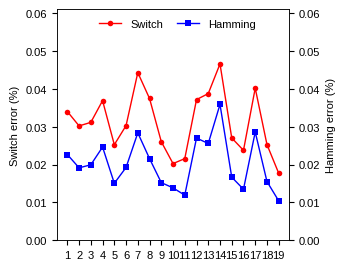

In [39]:
## Fig 3B. Dip3D phase set accuracy
compare_file=f'{Datadir}/Fig3/compare.tsv'
compare=pd.read_csv(compare_file,sep='\t',usecols=[1,6,7,8,9,10,13,14])
chr_list=[str(i) for i in  range(1,20)]+['X']
compare['chromosome']=pd.Categorical(compare.chromosome,categories=chr_list,ordered=True)
compare=compare.sort_values('chromosome').reset_index(drop=True)
compare=compare.head(19)
### bar and line plot
fig = plt.figure(figsize=(3,3))
ax1 = fig.add_subplot(111)

ax1.plot(compare.chromosome,compare.all_switch_rate*100,marker='.', markersize=8,color='r',label='Switch')
ax1.set_ylabel('Switch error (%)')
ax1.set_ylim(0,0.061)
ax1.legend(frameon=False,bbox_to_anchor=(0.5,1),ncol=2)

ax2 = ax1.twinx()
ax2.plot(compare.chromosome,compare.blockwise_hamming_rate*100,marker='s',markersize=5,color='b',label='Hamming')
ax2.set_ylabel('Hamming error (%)')
ax2.set_ylim(0,0.061)
ax2.legend(frameon=False,bbox_to_anchor=(0.9,1),ncol=2)

plt.xticks(compare.chromosome,compare.chromosome)
plt.xlabel("Chromosome")#,fontsize=12

fig=out_dir+'/mouse_switch_hamming_error.pdf'
plt.savefig(fig,dpi=300,bbox_inches = 'tight')